In [2]:
import os
import cv2
import csv
import math
import random
import numpy as np
import pandas as pd
import argparse

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
import torch.utils.data as data
import torch.nn.functional as F
from torch.autograd import Variable


from utils import *
from resnet import *


test_num = 0 ##### open class number


class RafDataset(data.Dataset):
    def __init__(self, args, phase, basic_aug=True, transform=None):
        self.raf_path = args.raf_path
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        df = pd.read_csv(args.label_path, sep=' ', header=None)

        name_c = 0
        label_c = 1
        if phase == 'train':
            dataset = df[df[name_c].str.startswith('train')]
        else:
            dataset = df[df[name_c].str.startswith('test')]

        
        
        self.label = dataset.iloc[:, label_c].values - 1
        images_names = dataset.iloc[:, name_c].values
        


        
        
        self.aug_func = [flip_image, add_g]
        self.file_paths = []

        for f in images_names:
            f = f.split(".")[0]
            f += '_aligned.jpg'
            file_name = os.path.join(self.raf_path, 'Image/aligned', f)
            self.file_paths.append(file_name)
            

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = cv2.imread(self.file_paths[idx])
        image = image[:, :, ::-1]

        if self.phase == 'train':

            if self.basic_aug and random.uniform(0, 1) > 0.5:
                index = random.randint(0, 1)
                image = self.aug_func[index](image)

        if self.transform is not None:
            image = self.transform(image)
        

        return image, label, idx
    

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class res18feature(nn.Module):
    def __init__(self, pretrained=True, num_classes=6, drop_rate=0.4, out_dim=64):
        super(res18feature, self).__init__()
        #'affectnet_baseline/resnet18_msceleb.pth'
        res18 = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=1000)
        
        msceleb_model = torch.load('./checkpoint/resnet18_msceleb.pth')
        state_dict = msceleb_model['state_dict']
        res18.load_state_dict(state_dict, strict=False)
        self.out_dim = out_dim
        self.features = nn.Sequential(*list(res18.children())[:-2])
        self.features2 = nn.Sequential(*list(res18.children())[-2:-1])
        self.fc = nn.Linear(args.out_dimension, 6)
        
        self.parm={}
        for name,parameters in self.fc.named_parameters():
            self.parm[name]=parameters
            
    def forward(self, x, target, phase='train'):
        x = self.features(x)        
        x = self.features2(x)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output





parser = argparse.ArgumentParser()
parser.add_argument('--raf_path', type=str, default='../data/raf-basic',help='raf_dataset_path')
parser.add_argument('--pretrained_backbone_path', type=str, default='../checkpoint/resnet18_msceleb.pth', help='pretrained_backbone_path')
parser.add_argument('--label_path', type=str, default='../data/raf-basic/EmoLabel/list_patition_label.txt', help='label_path')
parser.add_argument('--workers', type=int, default=8, help='number of workers')
parser.add_argument('--batch_size', type=int, default=128, help='batch_size')
parser.add_argument('--epochs', type=int, default=60, help='number of epochs')
parser.add_argument('--out_dimension', type=int, default=512, help='feature dimension')
args = parser.parse_args(args=[])


setup_seed(0)
res18 = res18feature(args)

        

data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) ])

data_transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) ])

train_dataset = RafDataset(args, phase='train', transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=args.batch_size,
                                           shuffle=True,
                                           num_workers=args.workers,
                                           pin_memory=True)



res18.cuda()
res18 = torch.nn.DataParallel(res18)

params = res18.parameters()
res18.module.load_state_dict(torch.load('0.pth')['model_state_dict'])

<All keys matched successfully>

In [5]:
class TESTRAF(data.Dataset):
    def __init__(self, args, phase, basic_aug=True, transform=None):
        self.raf_path = args.raf_path
        self.phase = phase
        self.basic_aug = basic_aug
        self.transform = transform
        df = pd.read_csv(args.label_path, sep=' ', header=None)
        name_c = 0
        label_c = 1

        dataset = df[df[name_c].str.startswith('test')]
        
        
        self.label = dataset.iloc[:, label_c].values - 1
        images_names = dataset.iloc[:, name_c].values
                

        self.aug_func = [flip_image, add_g]
        self.file_paths = []

        for f in images_names:
            f = f.split(".")[0]
            f += '_aligned.jpg'
            file_name = os.path.join(self.raf_path, 'Image/aligned', f)
            self.file_paths.append(file_name)
            

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.label[idx]
        image = cv2.imread(self.file_paths[idx])
        image = image[:, :, ::-1]
        image = self.transform(image)
        return image, label, idx
    
data_transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) ])

test_dataset = TESTRAF(args, phase='test', transform=data_transforms_val)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                          shuffle=False,
                                          num_workers=args.workers,
                                          pin_memory=True)   


with torch.no_grad():
    res18.eval()
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0
    data_num = 0
    total = []
    for batch_i, (imgs, labels, indexes) in enumerate(test_loader):
        imgs = imgs.cuda()
        labels = labels.cuda()
        output = res18(imgs, labels, phase='test')

        total.append(output.cpu().numpy())
    print('end...')

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


end...


In [6]:
new_total = np.concatenate(total)
test_score = new_total.max(axis=-1)
print(len(test_score))

3068


In [7]:
open_idx = []
ind_idx = []
for i in range(test_loader.dataset.__len__()):
    if test_loader.dataset.label[i] == test_num:
        open_idx.append(i)
    else:
        ind_idx.append(i)

## construct open-set using open-set samples from train set

In [9]:
with torch.no_grad():
    res18.eval()
    running_loss = 0.0
    iter_cnt = 0
    correct_sum = 0
    data_num = 0
    train_open = []
    for batch_i, (imgs, labels, indexes) in enumerate(train_loader):
        imgs = imgs.cuda()
        labels = labels.cuda()
        output = res18(imgs, labels, phase='test')
        train_open.append(output.cpu().numpy())
    print('end...')

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


end...


## find samples of open class (test_num) from train set

In [10]:
new_train_open = np.concatenate(train_open)
train_score = new_train_open.max(axis=-1)
train_open_idx = []
for i in range(train_loader.dataset.__len__()):
    if train_loader.dataset.label[i] == test_num:
        train_open_idx.append(i)
total_open_scores = np.concatenate((test_score[np.array(open_idx)], train_score[np.array(train_open_idx)]))
print(len(total_open_scores))

1619


## the distribution of close-set (closed class samples from test-set) and open-set (open class samples from both train-set and test-set)

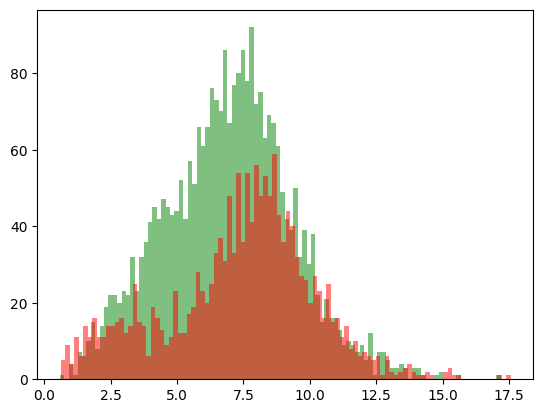

In [11]:
import matplotlib.pyplot as plt
plt.hist(test_score[np.array(ind_idx)], bins=100, alpha=0.5, color='green', label='known') 
plt.hist(total_open_scores, bins=100, alpha=0.5, color='red', label='open set(surprise)')
plt.show()

## open-set detection performance`

In [12]:
from tqdm import trange
import numpy as np

from ood_metrics import fpr_at_95_tpr
from ood_metrics import auroc
from tqdm import trange
import matplotlib.pyplot as plt


X1 = test_score[np.array(ind_idx)]
Y1 = total_open_scores

labels = np.concatenate((np.ones(len(X1)), np.zeros(len(Y1))))
scores = np.concatenate((X1, Y1))
fprBase = fpr_at_95_tpr(scores, labels)
aurocBase = auroc(scores, labels)
print(fprBase)
print(aurocBase)

0.9129092032118592
0.43684198301431904


## generate labels

In [13]:
total_predicts = np.concatenate((new_total, new_train_open[np.array(train_open_idx)]))
predicted_labels = np.argmax(total_predicts, axis=1)
total_image_paths = np.concatenate((test_loader.dataset.file_paths, np.array(train_loader.dataset.file_paths)[np.array(train_open_idx)]))
total_labels = np.concatenate((test_loader.dataset.label, np.array(train_loader.dataset.label)[np.array(train_open_idx)]))

## predict pseudo labels

In [19]:
new_file = open('predicted_labels_open'+str(test_num)+'.txt',"w+")
for i in range(len(predicted_labels)):
    new_file.write(total_image_paths[i] + ' ' + str(predicted_labels[i]) +'\n')

In [20]:
open_idx = []
ind_idx = []
for i in range(len(total_labels)):
    if total_labels[i] == test_num:
        open_idx.append(i)
    else:
        ind_idx.append(i)

In [21]:
print(len(open_idx))

1619


In [22]:
print(len(ind_idx))

2739


In [23]:
with open('predicted_labels_open'+str(test_num)+'_openset_index.txt', 'w+') as f:
    for i in range(len(open_idx)):
        f.write(str(open_idx[i]) +'\n')